In [1]:
import os
try:
    __IPYTHON__
    import sys
    del sys.argv[1:]
except:
    pass
import time 
%matplotlib inline 
import srwl_bl
import srwlib
import srwlpy
import uti_plot_com as srw_io
import srwl_uti_smp
import numpy as np
import matplotlib.pyplot as plt
from SRW_mp_helper import * 

In [2]:
def varparam_idxs(varParam, string):
    return varParam.index(string)

In [3]:
varParam = get_reset_varParam()

hOffsetIdx = varparam_idxs(varParam, ['op_Elliptical_Cylinder2_x', 'f', 0.0, 'horizontalOffset'])
vOffsetIdx = varparam_idxs(varParam,['op_Elliptical_Cylinder2_y', 'f', 0.0, 'verticalOffset'] )
file_idx = varparam_idxs(varParam,  ['ws_fni', 's', 'res_int_pr_se.dat', 'file name for saving propagated single-e intensity distribution vs horizontal and vertical position'])

nvx_idx = varparam_idxs(varParam, ['op_Elliptical_Cylinder_nvx', 'f', 0.999389625362475, 'normalVectorX'])
print(nvx_idx)
print(varParam[nvx_idx])

nvy_idx = varparam_idxs(varParam, ['op_Elliptical_Cylinder_nvy', 'f', 0.0, 'normalVectorY'])
print(nvy_idx)
print(varParam[nvy_idx])

nvz_idx = varparam_idxs(varParam, ['op_Elliptical_Cylinder_nvz', 'f', -0.03493389067727645, 'normalVectorZ'])
print(nvz_idx)
print(varParam[nvz_idx])
        

252
['op_Elliptical_Cylinder_nvx', 'f', 0.999389625362475, 'normalVectorX']
253
['op_Elliptical_Cylinder_nvy', 'f', 0.0, 'normalVectorY']
254
['op_Elliptical_Cylinder_nvz', 'f', -0.03493389067727645, 'normalVectorZ']


### Setup alignment and rotation errors 

In [21]:
n_runs = 10
zx_min = -1e-4
zx_max = 1e-4

theta_min = 0
theta_max = 0.1

offz1_vals = np.random.uniform(zx_min, zx_max, n_runs)
offz2_vals = np.random.uniform(zx_min, zx_max, n_runs)
thetaxs = np.random.uniform(theta_min, theta_max, n_runs)
thetays = np.random.uniform(theta_min, theta_max, n_runs)
thetazs = np.random.uniform(theta_min, theta_max, n_runs)

vx = varParam[nvx_idx][2]
vy = varParam[nvy_idx][2]
vz = varParam[nvz_idx][2]

In [24]:
start = time.time()
beam_arrays = [] 
for i in range(n_runs):
    if i % 10 == 0:
        print('run number ' + str(i))
        
    ### apply mirror offsets 
    horizontalOffset = offz1_vals[i]
    verticalOffset = offz2_vals[i]
    varParam[hOffsetIdx][2] = horizontalOffset
    varParam[vOffsetIdx][2] = verticalOffset
    
    ### apply rotation offset
    thetax = thetaxs[i]
    thetay = thetays[i]
    thetaz = thetazs[i]
    
    Rx = np.array([[1, 0, 0], [0, np.cos(thetax), -np.sin(thetax)], [0, np.sin(thetax), np.cos(thetax)]])
    Ry = np.array([[np.cos(thetay), 0, np.sin(thetay)], [0, 1, 0], [-np.sin(thetay), 0, np.cos(thetay)]])
    Rz = np.array([[np.cos(thetaz), -np.sin(thetaz), 0], [np.sin(thetaz), np.cos(thetaz), 0], [0, 0, 1]])
    
    Rxy = np.dot(Rx,Ry)
    R_tot = np.dot(Rxy,Rz)
    #print(R_tot.shape)
    v = np.array([vx, vy, vz]).reshape(3,1)
    #print(v.shape)
    
    rtot_v = np.dot(R_tot, v)
    #print(rtot_v.shape)
    

    varParam[nvx_idx][2] = rtot_v[0]
    
    varParam[nvy_idx][2]  = rtot_v[1]

    varParam[nvz_idx][2] = rtot_v[2]
    
    ### save file 
    save_dat = 'dat_files/res_int_se_' + str(i) + '.dat'
    varParam[file_idx][2] = save_dat
    
    v = srwl_bl.srwl_uti_parse_options(varParam, use_sys_argv=True)
    op = set_optics(v)
    v.si = True
    v.si_pl = ''
    v.ws = True
    v.ws_pl = ''
    mag = None
    if v.rs_type == 'm':
        mag = srwlib.SRWLMagFldC()
        mag.arXc.append(0)
        mag.arYc.append(0)
        mag.arMagFld.append(srwlib.SRWLMagFldM(v.mp_field, v.mp_order, v.mp_distribution, v.mp_len))
        mag.arZc.append(v.mp_zc)
    srwl_bl.SRWLBeamline(_name=v.name, _mag_approx=mag).calc_all(v, op)
    beam = read_srw_file(save_dat)
    h = beam.shape[0]
    w = beam.shape[1]
    beam_arrays.append(beam.reshape(h, w, 1))

    
end = time.time()
print('time to run ' + str(n_runs) + ' simulations :' + str(np.round((start - end)/60, 4)) + ' minutes')
all_errors = np.concatenate([offz1_vals.reshape(n_runs, 1), offz2_vals.reshape(n_runs, 1), thetaxs.reshape(n_runs, 1), thetays.reshape(n_runs, 1), thetazs.reshape(n_runs,1)], axis=1)
np.save('errors_' + str(n_runs) + 'runs.npy', all_errors)

beams_all = np.concatenate(beam_arrays, axis=2)
print(beams_all.shape)
np.save('beam_intensities_' + str(n_runs) + 'runs.npy', beams_all)

run number 0
(3, 3)
(3, 1)
(3, 1)
Gaussian beam electric field calculation ... completed (lasted 0.004 s)
Extracting intensity and saving it to a file ... completed (lasted 0.011 s)
Propagation ... completed (lasted 0.281 s)
Saving Propagation Results ... completed (lasted 0.071 s)
(3, 3)
(3, 1)
(3, 1)
Gaussian beam electric field calculation ... completed (lasted 0.005 s)
Extracting intensity and saving it to a file ... completed (lasted 0.012 s)
Propagation ... completed (lasted 0.253 s)
Saving Propagation Results ... completed (lasted 0.072 s)
(3, 3)
(3, 1)
(3, 1)
Gaussian beam electric field calculation ... completed (lasted 0.004 s)
Extracting intensity and saving it to a file ... completed (lasted 0.013 s)
Propagation ... completed (lasted 0.383 s)
Saving Propagation Results ... completed (lasted 0.115 s)
(3, 3)
(3, 1)
(3, 1)
Gaussian beam electric field calculation ... completed (lasted 0.004 s)
Extracting intensity and saving it to a file ... completed (lasted 0.011 s)
Propagat

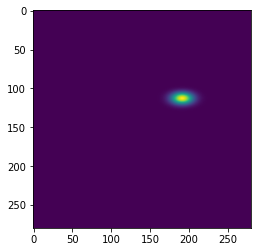

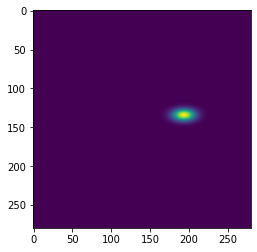

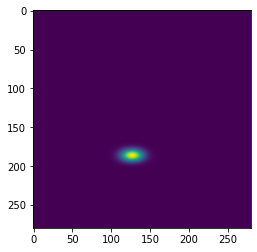

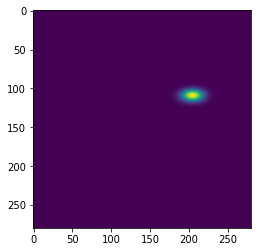

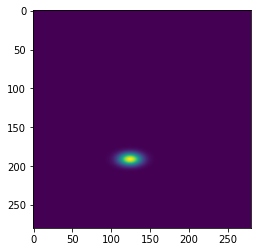

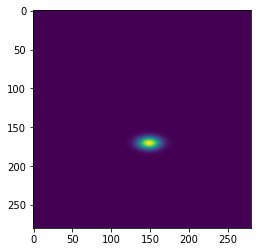

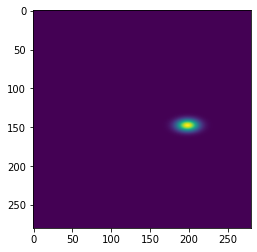

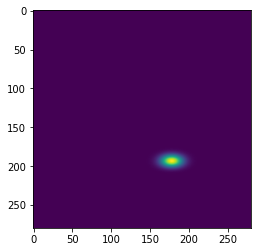

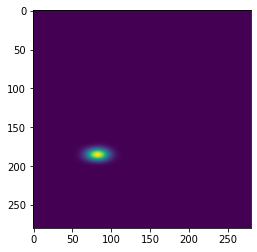

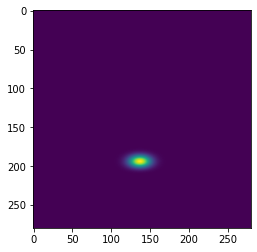

In [25]:
for i in range(10):
    plt.imshow(beams_all[:,:,i])
    plt.show()